Implementation of the paper -Solving the wave equation with physics-informed deep learning

In [7]:
def find_factors(n):
    factors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            factors.append((i, n // i))
    return factors

print(find_factors(1728051))  


[(1, 1728051), (3, 576017), (13, 132927), (39, 44309), (59, 29289), (177, 9763), (751, 2301), (767, 2253)]


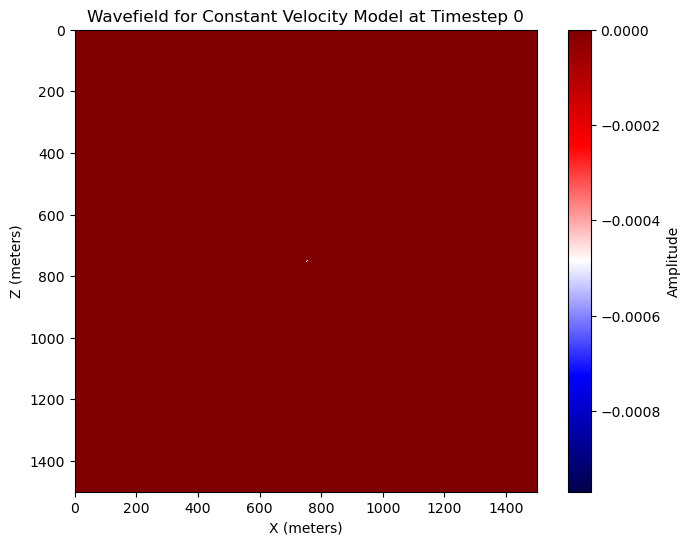

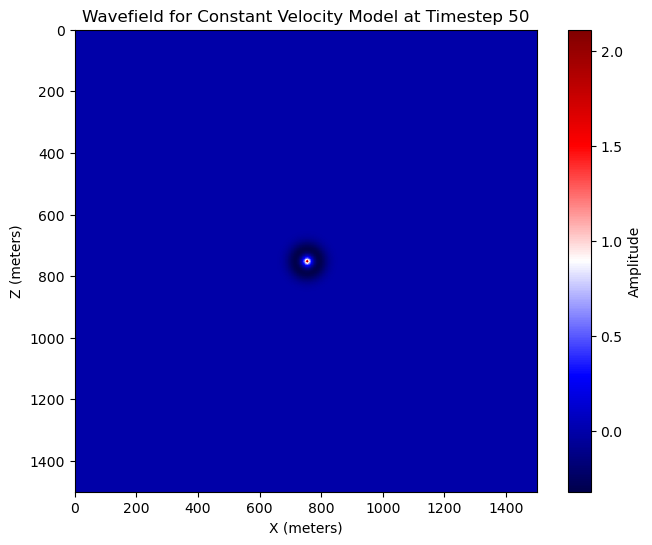

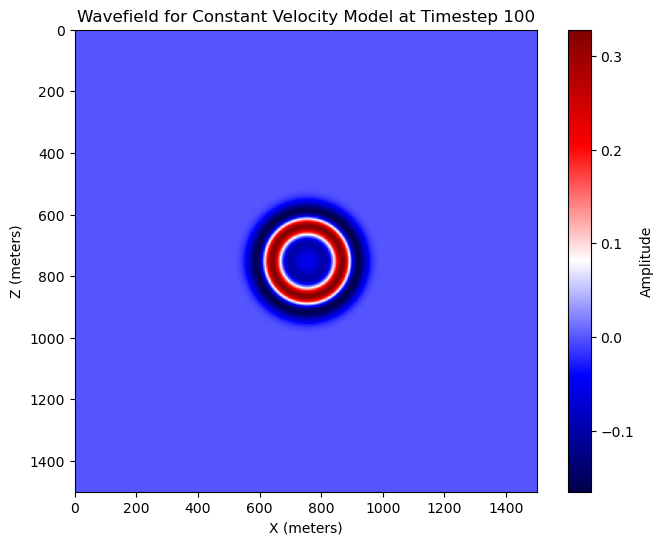

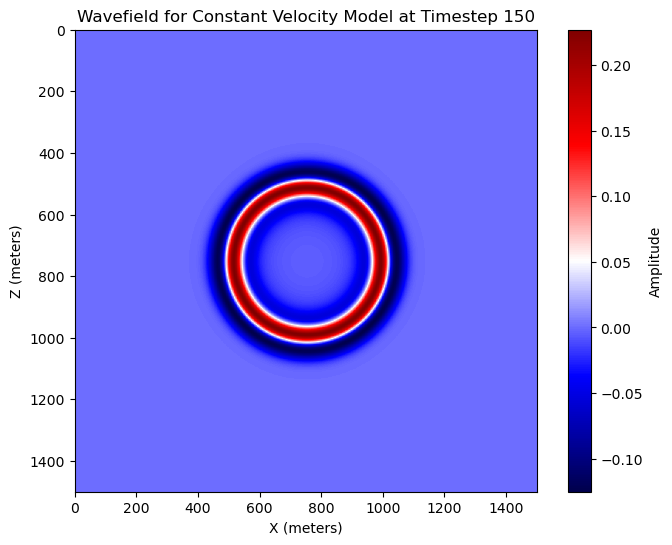

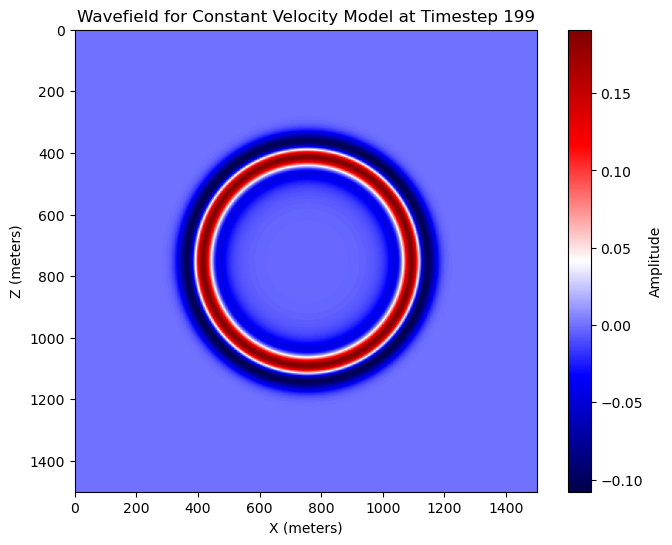

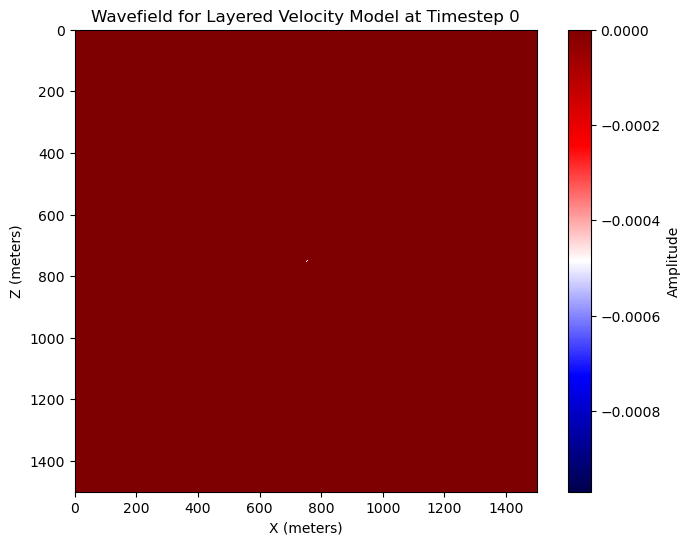

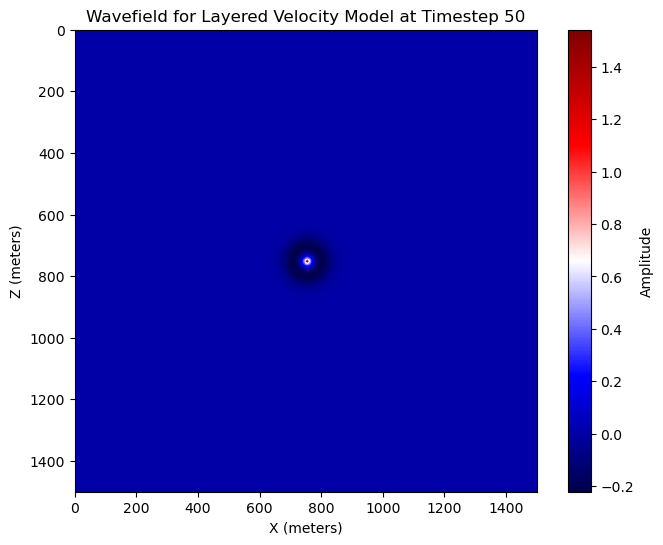

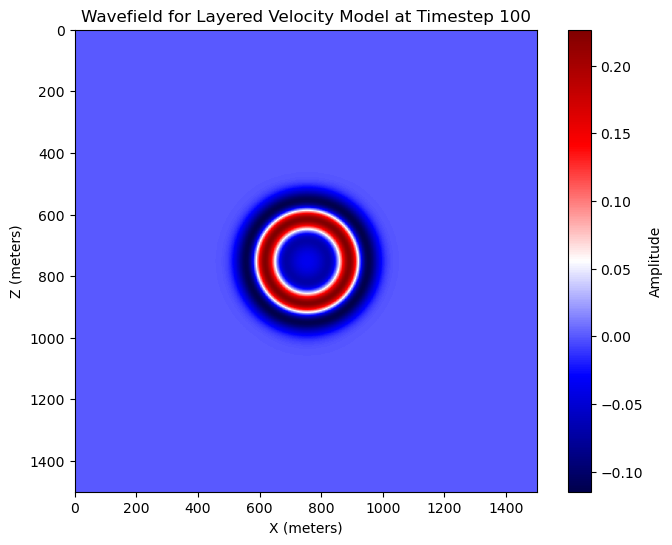

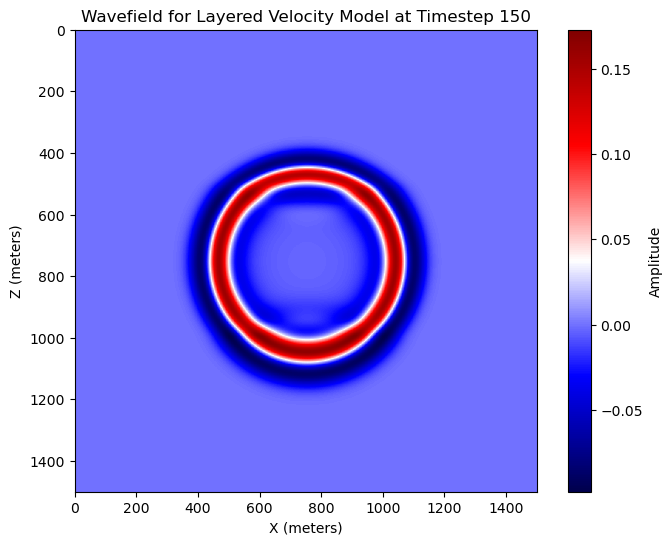

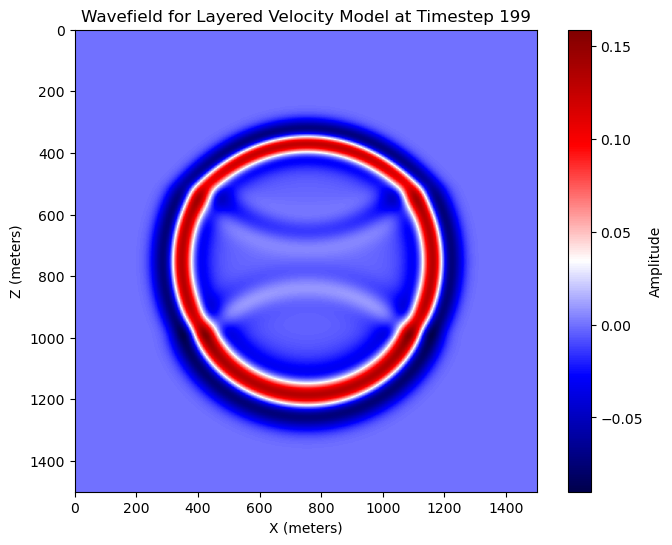

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# source time function (Ricker wavelet)
def ricker_wavelet(f0, t0, t):
    return (1 - 2 * (np.pi * f0 * (t - t0))**2) * np.exp(-(np.pi * f0 * (t - t0))**2)

# wave propagation solver
def wave_propagation(v, source, nx, nz, nt, dx, dz, dt, isx, isz):
    # Initialize wavefields
    p = np.zeros((nz, nx))
    pold = np.zeros((nz, nx))
    pnew = np.zeros((nz, nx))

    wavefields = []

    for it in range(nt):
        # second spatial derivatives
        d2px = (np.roll(p, -1, axis=1) - 2 * p + np.roll(p, 1, axis=1)) / dx**2
        d2pz = (np.roll(p, -1, axis=0) - 2 * p + np.roll(p, 1, axis=0)) / dz**2

        # Time extrapolation
        pnew = 2 * p - pold + (v**2) * (dt**2) * (d2px + d2pz)

        # source term
        pnew[isz, isx] += source[it]

        # Update wavefields
        pold, p = p, pnew

        if it % 10 == 0:
            wavefields.append(p.copy())

    return wavefields

# parameters
nx = 300
nz = 300
dx = 5.0
dz = dx
nt = 200
dt = 0.001
isx = 150
isz = 150
f0 = 20.0
t0 = 1.0 / f0

# source time function
time = np.arange(0, nt*dt, dt)
source = ricker_wavelet(f0, t0, time)

# constant velocity model
def constant_velocity_model(nz, nx):
    return np.full((nz, nx), 2500)

# layered velocity model
def layered_velocity_model(nz, nx):
    model = np.full((nz, nx), 2500)
    model[nz//3:2*nz//3, :] = 3000
    model[2*nz//3:, :] = 3500
    return model


velocity_models = {
    'Constant Velocity Model': (constant_velocity_model(nz, nx), nx, nz, isx, isz),
    'Layered Velocity Model': (layered_velocity_model(nz, nx), nx, nz, isx, isz)
}


for model_name, (v, nx, nz, isx, isz) in velocity_models.items():
    wavefields = wave_propagation(v, source, nx, nz, nt, dx, dz, dt, isx, isz)
    
    
    timesteps_to_plot = [0, 50, 100, 150, 199]

    for t in timesteps_to_plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(wavefields[t//10], cmap='seismic', extent=(0, nx*dx, nz*dz, 0))
        plt.colorbar(label='Amplitude')
        plt.title(f'Wavefield for {model_name} at Timestep {t}')
        plt.xlabel('X (meters)')
        plt.ylabel('Z (meters)')
        plt.show()


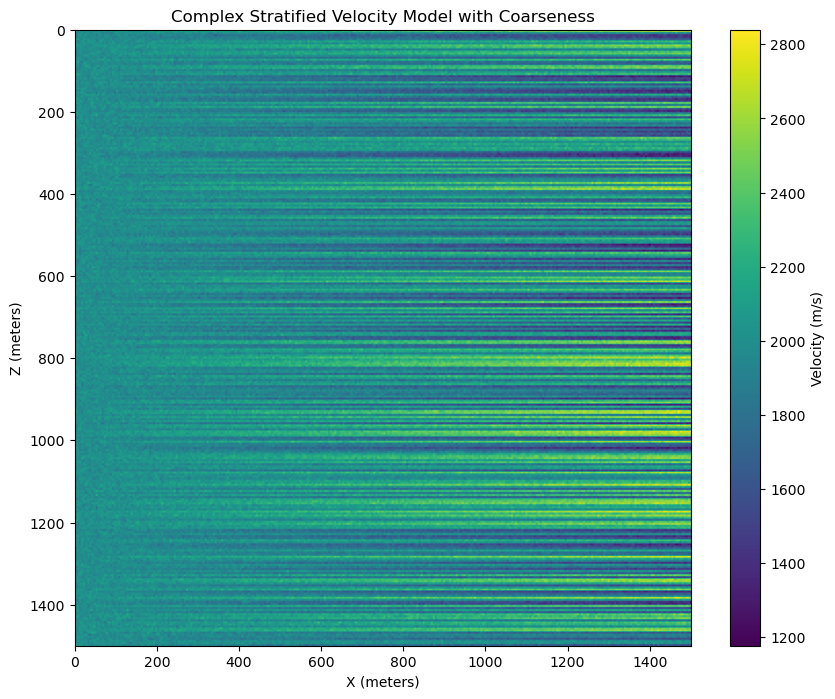

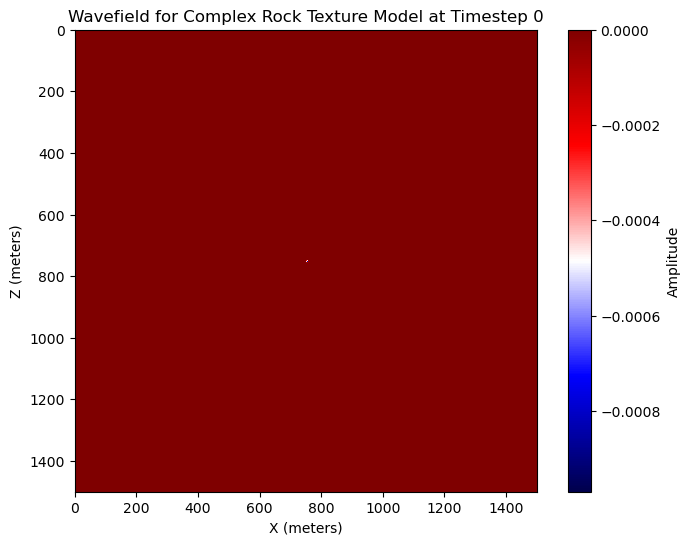

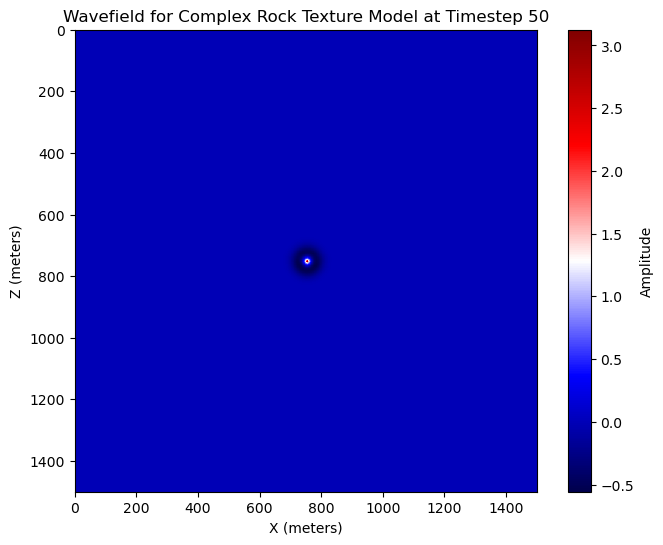

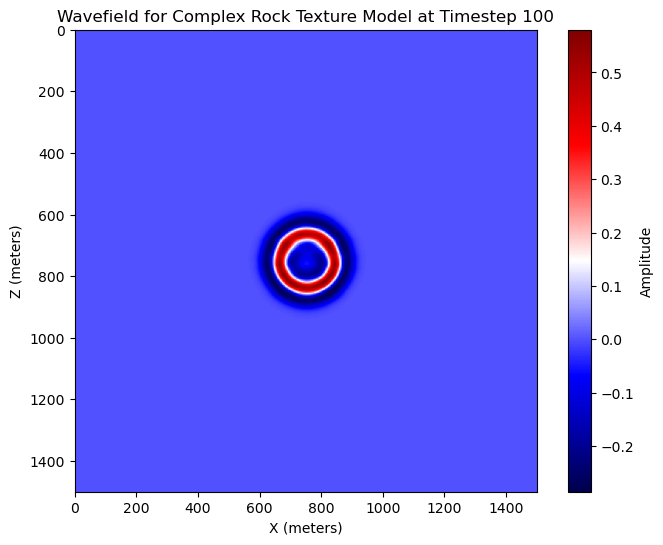

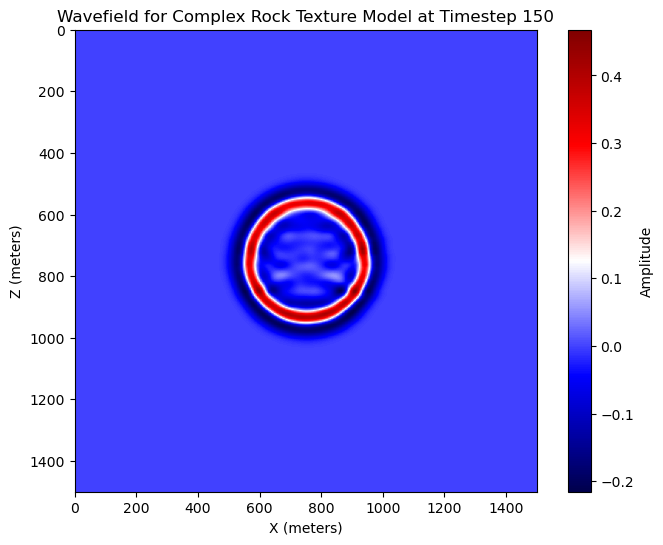

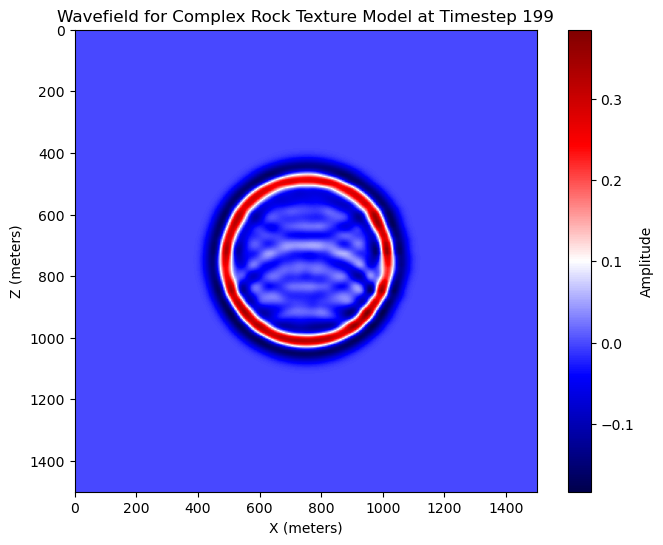

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# source time function (Ricker wavelet)
def ricker_wavelet(f0, t0, t):
    return (1 - 2 * (np.pi * f0 * (t - t0))**2) * np.exp(-(np.pi * f0 * (t - t0))**2)

# wave propagation solver
def wave_propagation(v, source, nx, nz, nt, dx, dz, dt, isx, isz):
    p = np.zeros((nz, nx))
    pold = np.zeros((nz, nx))
    pnew = np.zeros((nz, nx))

    wavefields = []

    for it in range(nt):
        # second spatial derivatives
        d2px = (np.roll(p, -1, axis=1) - 2 * p + np.roll(p, 1, axis=1)) / dx**2
        d2pz = (np.roll(p, -1, axis=0) - 2 * p + np.roll(p, 1, axis=0)) / dz**2

        # Time extrapolation
        pnew = 2 * p - pold + (v**2) * (dt**2) * (d2px + d2pz)

        # source term
        pnew[isz, isx] += source[it]

        # Update wavefields
        pold, p = p, pnew

        if it % 10 == 0:
            wavefields.append(p.copy())

    return wavefields

# parameters
nx = 300
nz = 300
dx = 5.0
dz = dx
nt = 200
dt = 0.001
isx = 150
isz = 150
f0 = 20.0
t0 = 1.0 / f0

# source time function
time = np.arange(0, nt*dt, dt)
source = ricker_wavelet(f0, t0, time)


def complex_rock_texture_velocity_model(nz, nx):
    model = np.zeros((nz, nx))

  
    layer_thicknesses = np.random.normal(20, 10, nz) 
    tilt_angles = np.random.uniform(-2.5, 2.5, nz)   

    # tilted and rough layers
    for i in range(nz):
        tilt_offset = tilt_angles[i] * np.arange(nx)
        rough_offset = np.random.normal(0, 10, nx)
        model[i, :] = 2000 + tilt_offset + rough_offset

        # coarseness based on layer properties
        if layer_thicknesses[i] < 15:
            model[i, :] -= np.random.normal(0, 30, nx)  # Additional roughness for thinner layers
        elif layer_thicknesses[i] > 25:
            model[i, :] += np.random.normal(0, 30, nx)  # Additional smoothness for thicker layers

    # more irregularities and variations in tilt angles and thicknesses
    for i in range(nz):
        if i % 3 == 0:
            model[i, :] += np.random.normal(0, 50, nx) 
        else:
            model[i, :] -= np.random.normal(0, 50, nx) 

    return model


plt.figure(figsize=(10, 8))
plt.imshow(complex_rock_texture_velocity_model(nz, nx), cmap='viridis', extent=(0, nx*dx, nz*dz, 0))
plt.colorbar(label='Velocity (m/s)')
plt.title('Complex Stratified Velocity Model with Coarseness')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.show()


velocity_models = {
    'Complex Rock Texture Model': (complex_rock_texture_velocity_model(nz, nx), nx, nz, isx, isz)
}

for model_name, (v, nx, nz, isx, isz) in velocity_models.items():
    wavefields = wave_propagation(v, source, nx, nz, nt, dx, dz, dt, isx, isz)
    
    
    timesteps_to_plot = [0, 50, 100, 150, 199]

    for t in timesteps_to_plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(wavefields[t//10], cmap='seismic', extent=(0, nx*dx, nz*dz, 0))
        plt.colorbar(label='Amplitude')
        plt.title(f'Wavefield for {model_name} at Timestep {t}')
        plt.xlabel('X (meters)')
        plt.ylabel('Z (meters)')
        plt.show()


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# simulate wave propagation using the finite difference method
def wave_propagation(v, source, nx, nz, nt, dx, dz, dt, isx, isz):
    p = np.zeros((nz, nx))
    pold = np.zeros((nz, nx))
    pnew = np.zeros((nz, nx))

    wavefields = []

    for it in range(nt):
        d2px = (np.roll(p, -1, axis=1) - 2 * p + np.roll(p, 1, axis=1)) / dx**2
        d2pz = (np.roll(p, -1, axis=0) - 2 * p + np.roll(p, 1, axis=0)) / dz**2
        pnew = 2 * p - pold + (v**2) * (dt**2) * (d2px + d2pz)
        pnew[isz, isx] += source[it]
        pold, p = p, pnew
        if it < 10:  # first 10 time steps after the source becomes negligible
            wavefields.append(p.copy())

    return np.array(wavefields)


def generate_initial_wavefield(nx, nz):
    x = np.linspace(-1, 1, nx)
    z = np.linspace(-1, 1, nz)
    X, Z = np.meshgrid(x, z)
    return np.exp(-0.5 * (X**2 + Z**2))


def complex_rock_texture_velocity_model(nz, nx):
    model = np.zeros((nz, nx))

    # Parameters for creating complex rock-like layers
    layer_thicknesses = np.random.normal(20, 10, nz)  
    tilt_angles = np.random.uniform(-2.5, 2.5, nz)   

    # Create tilted and rough layers
    for i in range(nz):
        tilt_offset = tilt_angles[i] * np.arange(nx)
        rough_offset = np.random.normal(0, 10, nx)
        model[i, :] = 2000 + tilt_offset + rough_offset

        if layer_thicknesses[i] < 15:
            model[i, :] -= np.random.normal(0, 30, nx)  
        elif layer_thicknesses[i] > 25:
            model[i, :] += np.random.normal(0, 30, nx)  

    
    for i in range(nz):
        if i % 3 == 0:
            model[i, :] += np.random.normal(0, 50, nx)  
        else:
            model[i, :] -= np.random.normal(0, 50, nx)  

    return model


def constant_velocity_model(nz, nx):
    return np.full((nz, nx), 2500)

def layered_velocity_model(nz, nx):
    model = np.full((nz, nx), 2500)
    model[nz//3:2*nz//3, :] = 3000
    model[2*nz//3:, :] = 3500
    return model

# Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim), nn.Softplus()])
        for _ in range(8):  
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Softplus())
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


nx, nz, nt = 300, 300, 200
dx, dz, dt = 5.0, 5.0, 0.001
isx, isz = nx // 2, nz // 2  # Source at the center
f0 = 20.0  # Frequency of the source
t0 = 0.05  # Delay of the source
time = np.linspace(0, nt * dt, nt)
source = (1 - 2 * (np.pi * f0 * (time - t0))**2) * np.exp(-(np.pi * f0 * (time - t0))**2)


def run_simulation(model_name, velocity_model):
    v = torch.tensor(velocity_model, dtype=torch.float32)
    
    wavefields = wave_propagation(velocity_model, source, nx, nz, nt, dx, dz, dt, isx, isz)
    
    
    wavefields_tensor = torch.from_numpy(wavefields).float()
    
    
    training_timesteps = 10
    x_train_list, z_train_list, t_train_list, u_train_list = [], [], [], []

    for t in range(training_timesteps):
        boundary_samples = wavefields_tensor[t, :, :]
        x_boundary = torch.linspace(0, nx * dx, nx).repeat(nz).view(-1, 1)
        z_boundary = torch.linspace(0, nz * dz, nz).repeat_interleave(nx).view(-1, 1)
        t_boundary = torch.ones(nx * nz, 1) * t * dt  # Time value for all samples in this timestep

        x_train_list.append(x_boundary)
        z_train_list.append(z_boundary)
        t_train_list.append(t_boundary)
        u_train_list.append(boundary_samples.view(-1, 1))

    x_train = torch.cat(x_train_list)
    z_train = torch.cat(z_train_list)
    t_train = torch.cat(t_train_list)
    u_train = torch.cat(u_train_list)

    
    model = PINN(input_dim=3, hidden_dim=1024, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    
    def physics_loss(model, x, z, t, v, dx, dz, dt):
        x.requires_grad = True
        z.requires_grad = True
        t.requires_grad = True
        p = model(torch.cat([x, z, t], dim=1))
        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_tt = torch.autograd.grad(p_t, t, grad_outputs=torch.ones_like(p_t), create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x), create_graph=True)[0]
        p_z = torch.autograd.grad(p, z, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_zz = torch.autograd.grad(p_z, z, grad_outputs=torch.ones_like(p_z), create_graph=True)[0]
        
        x_indices = torch.clamp((x / dx).long(), 0, nx - 1)
        z_indices = torch.clamp((z / dz).long(), 0, nz - 1)
        local_v = v[z_indices, x_indices].view(-1, 1)
        physics_term = p_tt - (local_v**2) * (p_xx / dx**2 + p_zz / dz**2)
        return (physics_term**2).mean()

    
    epochs = 1000
    batch_size = 500
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        if epoch < 200:  
            indices = torch.randperm(x_train.size(0))[:batch_size]
            outputs = model(torch.cat([x_train[indices], z_train[indices], t_train[indices]], dim=1))
            loss = criterion(outputs, u_train[indices])
        else:  
            random_indices = torch.randint(0, x_train.size(0), (batch_size,))
            x_physics = x_train[random_indices]
            z_physics = z_train[random_indices]
            t_physics = torch.rand(batch_size, 1) * nt * dt  

            outputs = model(torch.cat([x_physics, z_physics, t_physics], dim=1))
            loss_boundary = criterion(outputs, u_train[random_indices])
            loss_physics = physics_loss(model, x_physics, z_physics, t_physics, v, dx, dz, dt)
            
            loss = loss_boundary + loss_physics
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

    
    plt.figure(figsize=(10, 4))
    plt.plot(losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


    generated_wavefields = []
    for i in range(nt):
        t = torch.tensor(np.array([i * dt] * nz * nx), dtype=torch.float32).view(-1, 1)
        x = torch.tensor(np.repeat(np.linspace(0, nx * dx, nx), nz), dtype=torch.float32).view(-1, 1)
        z = torch.tensor(np.tile(np.linspace(0, nz * dz, nz), nx), dtype=torch.float32).view(-1, 1)
        inputs = torch.cat([x, z, t], dim=1)
        wavefield = model(inputs).detach().numpy().reshape(nz, nx)
        generated_wavefields.append(wavefield)
    
    return generated_wavefields


velocity_models = {
    'Constant Velocity Model': constant_velocity_model(nz, nx),
    'Layered Velocity Model': layered_velocity_model(nz, nx),
    'Complex Rock Texture Model': complex_rock_texture_velocity_model(nz, nx)
}


for model_name, velocity_model in velocity_models.items():
    print(f"Running simulation for {model_name}")
    generated_wavefields = run_simulation(model_name, velocity_model)

    
    timesteps_to_plot = [0, 50, 100, 150, 199]

    for t in timesteps_to_plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(generated_wavefields[t], cmap='seismic', extent=(0, nx*dx, nz*dz, 0))
        plt.colorbar(label='Amplitude')
        plt.title(f'Wavefield for {model_name} at Timestep {t}')
        plt.xlabel('X (meters)')
        plt.ylabel('Z (meters)')
        plt.show()


Running simulation for Constant Velocity Model
Epoch 0: Loss = 0.3508533239364624
Epoch 50: Loss = 0.0005848777364008129
Epoch 100: Loss = 1.4538097730110167e-06
Epoch 150: Loss = 2.713819355903979e-07
Epoch 200: Loss = 0.00025501492200419307
Epoch 250: Loss = 1.776763383531943e-05
Epoch 300: Loss = 1.1635414011834655e-05
Epoch 350: Loss = 2.7627465897239745e-05
Epoch 400: Loss = 8.863206312526017e-05
Epoch 450: Loss = 3.4820819564629346e-05
Epoch 500: Loss = 3.4880367820733227e-06
Epoch 550: Loss = 2.0639477043005172e-06
Epoch 600: Loss = 4.850406185141765e-06
Epoch 650: Loss = 1.1629827895376366e-05
Epoch 700: Loss = 3.929853846784681e-06
Epoch 750: Loss = 6.139287143014371e-05
Epoch 800: Loss = 4.026591341244057e-05
Epoch 850: Loss = 5.576299372478388e-05
Epoch 900: Loss = 6.107766239438206e-05


KeyboardInterrupt: 

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def wave_propagation_combined(v, sources, nx, nz, nt, dx, dz, dt, source_positions, anisotropy=None, attenuation=None):
    p = np.zeros((nz, nx))
    pold = np.zeros((nz, nx))
    pnew = np.zeros((nz, nx))

    wavefields = []

    for it in range(nt):
        d2px = (np.roll(p, -1, axis=1) - 2 * p + np.roll(p, 1, axis=1)) / dx**2
        d2pz = (np.roll(p, -1, axis=0) - 2 * p + np.roll(p, 1, axis=0)) / dz**2
        if anisotropy:
            d2px *= anisotropy['x']
            d2pz *= anisotropy['z']
        pnew = 2 * p - pold + (v**2) * (dt**2) * (d2px + d2pz)
        
        for source, (isx, isz) in zip(sources, source_positions):
            pnew[isz, isx] += source[it]
        
        if attenuation:
            pnew *= np.exp(-attenuation * dt)
        
        pold, p = p, pnew
        if it < 10:
            wavefields.append(p.copy())

    return np.array(wavefields)

# parameters
nx, nz, nt = 300, 300, 200
dx, dz, dt = 5.0, 5.0, 0.001
f0 = 20.0
t0 = 0.05
time = np.linspace(0, nt * dt, nt)

# multiple sources
sources = []
for i in range(5):
    source = (1 - 2 * (np.pi * f0 * (time - (t0 + i * 0.01)))**2) * np.exp(-(np.pi * f0 * (time - (t0 + i * 0.01)))**2)
    sources.append(source)

# source positions
source_positions = [(nx // 5, nz // 5), (2 * nx // 5, 2 * nz // 5), (3 * nx // 5, 3 * nz // 5), (4 * nx // 5, 4 * nz // 5), (nx // 2, nz // 2)]

# Anisotropy parameters
anisotropy = {'x': 1.2, 'z': 0.8}

# Attenuation parameter
attenuation = 0.01

# constant velocity model
def constant_velocity_model(nz, nx):
    return np.full((nz, nx), 2500)

# layered velocity model
def layered_velocity_model(nz, nx):
    model = np.full((nz, nx), 2500)
    model[nz//3:2*nz//3, :] = 3000
    model[2*nz//3:, :] = 3500
    return model

# complex stratified velocity model resembling rock textures with varying tilt angles, irregularities, and coarseness
def complex_rock_texture_velocity_model(nz, nx):
    model = np.zeros((nz, nx))

    layer_thicknesses = np.random.normal(20, 10, nz)
    tilt_angles = np.random.uniform(-2.5, 2.5, nz)

    for i in range(nz):
        tilt_offset = tilt_angles[i] * np.arange(nx)
        rough_offset = np.random.normal(0, 10, nx)
        model[i, :] = 2000 + tilt_offset + rough_offset

        if layer_thicknesses[i] < 15:
            model[i, :] -= np.random.normal(0, 30, nx)
        elif layer_thicknesses[i] > 25:
            model[i, :] += np.random.normal(0, 30, nx)

        if i % 3 == 0:
            model[i, :] += np.random.normal(0, 50, nx)
        else:
            model[i, :] -= np.random.normal(0, 50, nx)

    return model

# Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim), nn.Softplus()])
        for _ in range(8):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Softplus())
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def run_simulation(model_name,velocity_model, sources, source_positions, anisotropy=None, attenuation=None):
    v = torch.tensor(velocity_model, dtype=torch.float32)
    wavefields = wave_propagation_combined(velocity_model, sources, nx, nz, nt, dx, dz, dt, source_positions, anisotropy, attenuation)
    
    wavefields_tensor = torch.from_numpy(wavefields).float()
    
    training_timesteps = 10
    x_train_list, z_train_list, t_train_list, u_train_list = [], [], [], []

    for t in range(training_timesteps):
        boundary_samples = wavefields_tensor[t, :, :]
        x_boundary = torch.linspace(0, nx * dx, nx).repeat(nz).view(-1, 1)
        z_boundary = torch.linspace(0, nz * dz, nz).repeat_interleave(nx).view(-1, 1)
        t_boundary = torch.ones(nx * nz, 1) * t * dt

        x_train_list.append(x_boundary)
        z_train_list.append(z_boundary)
        t_train_list.append(t_boundary)
        u_train_list.append(boundary_samples.view(-1, 1))

    x_train = torch.cat(x_train_list)
    z_train = torch.cat(z_train_list)
    t_train = torch.cat(t_train_list)
    u_train = torch.cat(u_train_list)

    model = PINN(input_dim=3, hidden_dim=1024, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    def physics_loss(model, x, z, t, v, dx, dz, dt):
        x.requires_grad = True
        z.requires_grad = True
        t.requires_grad = True
        p = model(torch.cat([x, z, t], dim=1))
        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_tt = torch.autograd.grad(p_t, t, grad_outputs=torch.ones_like(p_t), create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x), create_graph=True)[0]
        p_z = torch.autograd.grad(p, z, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_zz = torch.autograd.grad(p_z, z, grad_outputs=torch.ones_like(p_z), create_graph=True)[0]
        
        x_indices = torch.clamp((x / dx).long(), 0, nx - 1)
        z_indices = torch.clamp((z / dz).long(), 0, nz - 1)
        local_v = v[z_indices, x_indices].view(-1, 1)
        physics_term = p_tt - (local_v**2) * (p_xx / dx**2 + p_zz / dz**2)
        return (physics_term**2).mean()

    epochs = 1000
    batch_size = 500
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        if epoch < 200:
            indices = torch.randperm(x_train.size(0))[:batch_size]
            outputs = model(torch.cat([x_train[indices], z_train[indices], t_train[indices]], dim=1))
            loss = criterion(outputs, u_train[indices])
        else:
            random_indices = torch.randint(0, x_train.size(0), (batch_size,))
            x_physics = x_train[random_indices]
            z_physics = z_train[random_indices]
            t_physics = torch.rand(batch_size, 1) * nt * dt

            outputs = model(torch.cat([x_physics, z_physics, t_physics], dim=1))
            loss_boundary = criterion(outputs, u_train[random_indices])
            loss_physics = physics_loss(model, x_physics, z_physics, t_physics, v, dx, dz, dt)
            
            loss = loss_boundary + loss_physics
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

    return losses, wavefields_tensor


velocity_models = {
    'Constant Velocity Model': constant_velocity_model(nz, nx),
    'Layered Velocity Model': layered_velocity_model(nz, nx),
    'Complex Rock Texture Model': complex_rock_texture_velocity_model(nz, nx)
}


losses_dict = {}


for model_name, velocity_model in velocity_models.items():
    print(f"Running simulation with multiple sources for {model_name}")
    losses_multiple_sources, wavefields_multiple_sources = run_simulation(f"Multiple Sources - {model_name}", velocity_model, sources, source_positions)
    losses_dict[f'Multiple Sources - {model_name}'] = losses_multiple_sources


plt.figure(figsize=(12, 8))
for label, losses in losses_dict.items():
    plt.plot(losses, label=label)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Multiple Sources')
plt.legend()
plt.grid(True)
plt.show()

# Anisotropy
for model_name, velocity_model in velocity_models.items():
    print(f"Running simulation with anisotropy for {model_name}")
    losses_anisotropy, _ = run_simulation(f"Anisotropy - {model_name}", velocity_model, [sources[0]], [source_positions[0]], anisotropy=anisotropy)
    losses_dict[f'Anisotropy - {model_name}'] = losses_anisotropy

# Attenuation
for model_name, velocity_model in velocity_models.items():
    print(f"Running simulation with attenuation for {model_name}")
    losses_attenuation, _ = run_simulation(f"Attenuation - {model_name}", velocity_model, [sources[0]], [source_positions[0]], attenuation=attenuation)
    losses_dict[f'Attenuation - {model_name}'] = losses_attenuation
    
plt.figure(figsize=(12, 8))
for label, losses in losses_dict.items():
    plt.plot(losses, label=label)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

# each source separately
for model_name, velocity_model in velocity_models.items():
    for i, source in enumerate(sources):
        plt.figure(figsize=(12, 8))
        for t in [0, 50, 100, 150, 199]:
            plt.subplot(2, 3, t//50 + 1)
            plt.imshow(wavefields_multiple_sources[t], cmap='seismic', extent=(0, nx*dx, nz*dz, 0))
            plt.colorbar(label='Amplitude')
            plt.title(f'Source {i+1} - Timestep {t}')
        plt.suptitle(f'Wavefields for {model_name} - Source {i+1}')
        plt.show()


Running simulation with multiple sources for Constant Velocity Model


TypeError: new(): invalid data type 'str'